<a target="_blank" href="https://colab.research.google.com/github/05Alston/forged-signature-detector/blob/main/model.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

In [ ]:
!rm -fr sample_data
!rm -fr test_data
!rm -fr train_data
!rm -fr validation_data

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Preprocessing

In [ ]:
import cv2
import os
from tqdm import tqdm
import random

if not os.path.exists('train_data/'):
  os.mkdir('train_data')
if not os.path.exists('validation_data/'):
  os.mkdir('validation_data')
if not os.path.exists('test_data/'):
  os.mkdir('test_data')

drive_path = './drive/MyDrive/dataset/'

orig_images = []
forg_images = []
for name in tqdm(sorted(os.listdir(drive_path+'train/'))):
    if 'forg' in name.lower():
        forg_images.append(len(os.listdir(drive_path+'train/'+name)))
    else:
        orig_images.append(len(os.listdir(drive_path+'train/'+name)))

num_orig = min(orig_images)
num_forg = min(forg_images)
tot_people = len(os.listdir(drive_path+'train/'))//2

num_train = 100
num_validation = 20
num_test = 40
for name in tqdm(sorted(os.listdir(drive_path+'train/'))):
    if num_train > 0:
        if not os.path.exists('train_data/'+name):
          os.mkdir('train_data/'+name)
        if 'forg' in name.lower():
            i = num_forg
        else:
            i = num_orig
        for image_name in sorted(os.listdir(drive_path+'train/'+name)):
            if i <= 0:
                break
            img = cv2.imread(drive_path+'train/'+name+'/'+image_name)
            img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
            img_resized = cv2.resize(img_gray, (730, 376))
            cv2.imwrite('train_data/'+name+'/'+image_name, img_resized)
            i -= 1
        num_train -= 1
    if num_validation > 0 and random.randint(0,1) == 1:
        if not os.path.exists('validation_data/'+name):
          os.mkdir('validation_data/'+name)
        if 'forg' in name.lower():
            i = num_forg
        else:
            i = num_orig
        for image_name in sorted(os.listdir(drive_path+'train/'+name)):
            if i <= 0:
                break
            img = cv2.imread(drive_path+'train/'+name+'/'+image_name)
            img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
            img_resized = cv2.resize(img_gray, (730, 376))
            cv2.imwrite('validation_data/'+name+'/'+image_name,
                        img_resized)
            i -= 1
        num_validation -= 1
    if num_test > 0:
        if not os.path.exists('test_data/'+name):
          os.mkdir('test_data/'+name)
        if 'forg' in name.lower():
            i = num_forg
        else:
            i = num_orig
        for image_name in sorted(os.listdir(drive_path+'test/'+name)):
            if i <= 0:
                break
            img = cv2.imread(drive_path+'test/'+name+'/'+image_name)
            img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
            img_resized = cv2.resize(img_gray, (730, 376))
            cv2.imwrite('test_data/'+name+'/'+image_name, img_resized)
            i -= 1
        num_test -= 1


100%|██████████| 60/60 [01:24<00:00,  1.41s/it]


# Model

In [ ]:
import os
import numpy as np
import cv2
from tqdm import tqdm
import matplotlib.pyplot as plt
import itertools
import random
from sklearn.utils import shuffle
from keras import layers, models, optimizers, callbacks
from keras import backend as K

In [ ]:
def get_data(dir):
    orig = []
    forg = []
    for name in tqdm(sorted(os.listdir(dir))):
        original = []
        forged = []
        for image_name in sorted(os.listdir(dir+'/'+name)):
            img = dir+'/'+name+'/'+image_name
            if 'forg' in name.lower():
                forged.append(img)
            else:
                original.append(img)

        if 'forg' in name.lower():
            forg.append(forged)
        else:
            orig.append(original)

    return orig, forg

In [ ]:
train_orig, train_forg = get_data('train_data')
validation_orig, validation_forg = get_data('validation_data')
test_orig, test_forg = get_data('test_data')

100%|██████████| 40/40 [00:00<00:00, 31184.42it/s]


In [ ]:
print(len(train_orig))
print(len(train_forg))
print(len(validation_orig))
print(len(validation_forg))
print(len(test_orig))
print(len(test_forg))

30
30
12
8
20
20


In [ ]:
def euclidean_distance(vects):
    '''
    Compute Euclidean Distance between two vectors
    '''
    (featsA, featsB) = vects
    squared_diff = K.square(featsA - featsB)
    return K.sqrt(K.sum(squared_diff, axis=1, keepdims=True))


def eucl_dist_output_shape(shapes):
    shape1, shape2 = shapes
    return (shape1[0], 1)

In [ ]:
def generate_batch(orig_groups, forg_groups, batch_size = 32):
    '''
    Function to generate a batch of data with batch_size number of data
    points. Half of the data points will be Genuine-Genuine pairs and half
    will be Genuine-Forged pairs
    '''
    while True:
        orig_pairs = []
        forg_pairs = []
        gen_gen_labels = []
        gen_for_labels = []
        all_pairs = []
        all_labels = []

        for orig, forg in zip(orig_groups, forg_groups):
            orig_pairs.extend(list(itertools.combinations(orig, 2)))
            for i in range(len(orig)):
                forg_pairs.extend(list(
                    itertools.product(orig[i:i+1],
                                      forg)))

        gen_gen_labels = [1]*len(orig_pairs)
        gen_for_labels = [0]*len(forg_pairs)

        all_pairs = orig_pairs + forg_pairs
        all_labels = gen_gen_labels + gen_for_labels
        del orig_pairs, forg_pairs, gen_gen_labels, gen_for_labels
        all_pairs, all_labels = shuffle(all_pairs, all_labels)

        k = 0
        pairs=[np.zeros((batch_size, 376, 730, 1)) for i in range(2)]
        targets=np.zeros((batch_size,))
        for ix, pair in enumerate(all_pairs):
            img1 = cv2.imread(pair[0], cv2.IMREAD_GRAYSCALE)
            img2 = cv2.imread(pair[1], cv2.IMREAD_GRAYSCALE)
            img1 = np.array(img1, dtype = np.float64)
            img2 = np.array(img2, dtype = np.float64)
            img1 /= 255
            img2 /= 255
            img1 = img1[..., np.newaxis]
            img2 = img2[..., np.newaxis]
            pairs[0][k, :, :, :] = img1
            pairs[1][k, :, :, :] = img2
            targets[k] = all_labels[ix]
            k += 1
            if k == batch_size:
                yield pairs, targets
                k = 0
                pairs=[np.zeros((batch_size,
                                 376, 730, 1)) for i in range(2)]
                targets=np.zeros((batch_size,))

In [ ]:
def create_base_network_signal(input_shape):
    '''
    Base Siamese Network
    '''

    convnet = models.Sequential()
    convnet.add(layers.Convolution2D(64, (3, 3), input_shape=input_shape))
    convnet.add(layers.Activation('relu'))
    convnet.add(layers.MaxPooling2D(pool_size=(2, 2)))

    convnet.add(layers.Convolution2D(32, (3, 3)))
    convnet.add(layers.Activation('relu'))
    convnet.add(layers.MaxPooling2D(pool_size=(2, 2)))

    # flatten
    convnet.add(layers.Flatten())
    convnet.add(layers.Dense(128, activation='relu'))
    convnet.add(layers.Dense(64, activation='relu'))


    return convnet

In [ ]:
input_shape=(730, 376,1)
base_network = create_base_network_signal(input_shape)

input_a = layers.Input(shape=(input_shape))
input_b = layers.Input(shape=(input_shape))

processed_a = base_network(input_a)
processed_b = base_network(input_b)

distance = layers.Lambda(euclidean_distance,
                         output_shape=eucl_dist_output_shape
                         )([processed_a, processed_b])
prediction = layers.Dense(1,
                          activation='sigmoid'
                          )(distance)
earlyStopping_callback = callbacks.EarlyStopping(monitor='val_loss',
                              min_delta=0,
                              patience=3,
                              verbose=1)
model = models.Model(inputs=[input_a, input_b],
                     outputs=prediction)

In [ ]:
model.compile(optimizer=optimizers.Adam(lr=0.00008),
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [ ]:
batch_size=16
history = model.fit(
    generate_batch(train_orig, train_forg, batch_size),
                   steps_per_epoch = 120,
                   epochs = 10,
                   validation_data = generate_batch(validation_orig, validation_forg, batch_size),
                   validation_steps = 12)

Epoch 1/10
120/120 [==============================] - 32s 265ms/step - loss: 0.2513 - accuracy: 0.8172 - val_loss: 0.2399 - val_accuracy: 0.8698
Epoch 2/10
120/120 [==============================] - 32s 265ms/step - loss: 0.2469 - accuracy: 0.8495 - val_loss: 0.2533 - val_accuracy: 0.8073
Epoch 3/10
120/120 [==============================] - 32s 265ms/step - loss: 0.2400 - accuracy: 0.8573 - val_loss: 0.2666 - val_accuracy: 0.8906
Epoch 4/10
120/120 [==============================] - 31s 257ms/step - loss: 0.2359 - accuracy: 0.8719 - val_loss: 0.2518 - val_accuracy: 0.8385
Epoch 5/10
120/120 [==============================] - 31s 259ms/step - loss: 0.2432 - accuracy: 0.8833 - val_loss: 0.2759 - val_accuracy: 0.9167
Epoch 6/10
120/120 [==============================] - 32s 264ms/step - loss: 0.2361 - accuracy: 0.8938 - val_loss: 0.2061 - val_accuracy: 0.9323
Epoch 7/10
120/120 [==============================] - 31s 261ms/step - loss: 0.2340 - accuracy: 0.9068 - val_loss: 0.2478 - val_ac

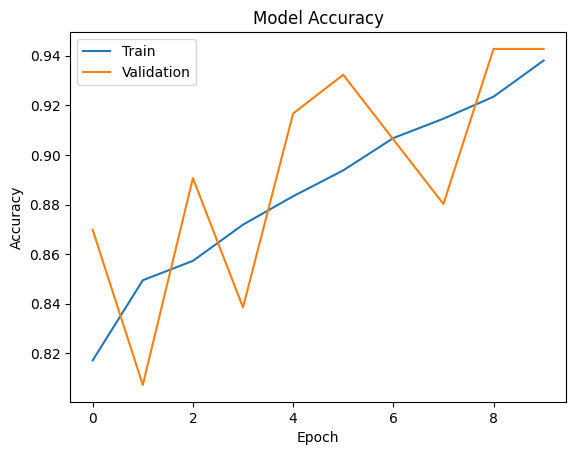

Final Training Accuracy: 93.80%
Final Validation Accuracy: 94.27%
Training accuracy: 0.9380208253860474
Validation accuracy: 0.9427083134651184


In [ ]:
# Plot the training and validation accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Print the final training and validation accuracy
print("Final Training Accuracy: {:.2f}%".format(history.history['accuracy'][-1]*100))
print("Final Validation Accuracy: {:.2f}%".format(history.history['val_accuracy'][-1]*100))
print("Training accuracy:", history.history['accuracy'][-1])
print("Validation accuracy:", history.history['val_accuracy'][-1])

In [ ]:
model.save('siamese-test.h5')

In [ ]:
!ls -l

total 799688
drwx------  5 root root      4096 Jun 18 16:54 drive
-rw-r--r--  1 root root 818858216 Jun 18 17:13 siamese-test.h5
drwxr-xr-x 42 root root      4096 Jun 18 16:55 test_data
drwxr-xr-x 62 root root      4096 Jun 18 16:55 train_data
drwxr-xr-x 22 root root      4096 Jun 18 16:55 validation_data
